1. 라이브러리 호출

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2. FashionMNIST DataSet Download

In [3]:
train_dataset = torchvision.datasets.FashionMNIST("../CNN/data/", download=True, transform=transforms.Compose([transforms.ToTensor()]))
# param1 : FashionMNIST dataset을 내려받을 위치를 지정함.
# param2 : param1에 dataset 유무 확인 후 내려받음
# param3 : image를 tensor(0~1)로 변경함.

test_dataset = torchvision.datasets.FashionMNIST("../CNN/data/", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

3. Data를 DataLoader에 전달

In [4]:
# torch.utils.data.DataLoader() : 원하는 크기의 배치 단위로 데이터를 불러오거나 순서가 무작위로 섞이도록 함.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

4. Classification에 사용될 Class 정의

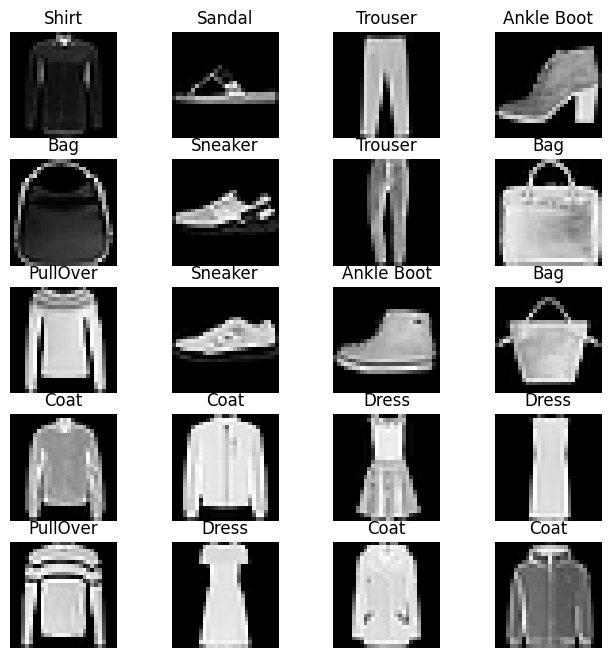

In [5]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'PullOver', 3 : 'Dress', 4 : 'Coat',
              5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8)) # 출력할 이미지는 8 inch x 8 inch

columns = 4;
rows = 5;

for i in range (1, columns*rows +1):
  img_xy = np.random.randint(len(train_dataset)); # 0 ~ len(train_dataset) 값을 갖는 분포에서 random으로 숫자 한 개 생성
  img = train_dataset[img_xy][0][0,:,:] # train_dataset을 이용해 3d array 생성
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show()

5. 심층 신경망 모델 생성

In [6]:
class FashionDNN(nn.Module):
  def __init__(self): # 객체 생성자
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256) # 선형 회귀 모델을 만듦.
    self.drop = nn.Dropout(0.25)  # p 만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커짐.
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data): # 모델이 학습 데이터를 입력받아 순전파 학습을 진행시키는 함수
    out = input_data.view(-1, 784) # numpy의 reshape와 같은 역할이며 텐서의 크기를 변경해줌.input_data를 (?, 784)로 변경하라는 의미
    out = F.relu(self.fc1(out)) # 활성화 함수
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out


6. Parameter 정의

In [7]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate); # Adam Optimizer 사용
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


7. 모델 학습

In [8]:
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


Iteration: 500, Loss: 0.5978282690048218, Accuracy: 82.9800033569336%
Iteration: 1000, Loss: 0.4464547336101532, Accuracy: 84.63999938964844%
Iteration: 1500, Loss: 0.32835182547569275, Accuracy: 84.48999786376953%
Iteration: 2000, Loss: 0.3400656580924988, Accuracy: 85.19999694824219%
Iteration: 2500, Loss: 0.22091026604175568, Accuracy: 86.16000366210938%
Iteration: 3000, Loss: 0.29679375886917114, Accuracy: 86.58999633789062%
